# Plant Seedlings Classifier

https://www.kaggle.com/c/plant-seedlings-classification

One time setup

`# ln -s ../../data data`

`# ln -s ../../fastai/fastai fastai`

`# mkdir ./data/plant-seedlings`

`# cd data/plant-seedlings`

`# kg download -u <username> -p <password> -c plant-seedlings`

`# run setup jupyter notebook`

In [21]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [22]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [23]:
arch = resnet50
sz = 224
bs = 32

In [24]:
PATH = './data/plant-seedlings/'
label_csv = f'{PATH}labels.csv'

n = len(list(open(label_csv)))-1

val_idxs = get_cv_idxs(n)

# Transform Data

In [25]:
def get_data(sz, bs, val):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train' ,f'{PATH}labels.csv', test_name='test',
                                    val_idxs=val, tfms=tfms, bs=bs)
    return data

# Find Learning Rate

In [26]:
data = get_data(sz,bs,val_idxs)

In [27]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [28]:
lrf = learn.lr_find()

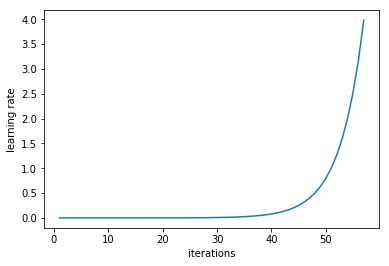

In [29]:
learn.sched.plot_lr()

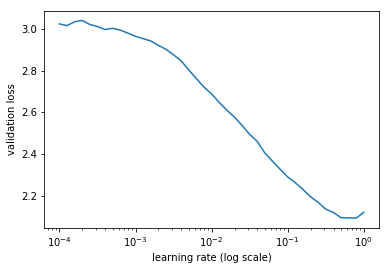

In [30]:
learn.sched.plot()

In [31]:
lr = 1e-2

In [32]:
#lrs=np.array([lr/24,lr/8,lr/2])
lrs=np.array([lr/100,lr/10,lr])

# Fit Model, Toggle Precompute and Unfreeze Earlier Layers

In [12]:
learn.fit(lr,1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.987952   0.648916   0.772632  



[array([0.64892]), 0.7726315791042228]

In [33]:
learn.precompute = False

In [14]:
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.739771   0.513011   0.831579  
    1      0.694307   0.487057   0.834737                    
    2      0.64155    0.44833    0.84                        



[array([0.44833]), 0.8400000001254835]

In [15]:
learn.save('resnet50_224_lastlayer')

In [16]:
learn.load('resnet50_224_lastlayer')

In [17]:
learn.unfreeze()

In [19]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.422545   0.234124   0.906316  
    1      0.301149   0.169264   0.945263                    
    2      0.211501   0.146888   0.946316                    
    3      0.20232    0.167496   0.937895                    
    4      0.160821   0.127378   0.951579                    
    5      0.132657   0.11826    0.958947                    
    6      0.104223   0.109476   0.961053                    



[array([0.10948]), 0.9610526317044308]

In [20]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.9673684210526315, 0.10092393602679085)

In [21]:
learn.save('resnet50_224_all')

In [22]:
learn.load('resnet50_224_all')

# Increase Data Image Size and Repeat Previous Steps

In [34]:
sz = 320

In [24]:
data = get_data(sz,bs,val_idxs)
learn.set_data(data)

In [25]:
learn.freeze()

In [26]:
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.128337   0.111483   0.964211  
    1      0.107883   0.10949    0.967368                    
    2      0.102397   0.112534   0.963158                    



[array([0.11253]), 0.9631578952387759]

In [27]:
learn.save('resnet50_320_last_layer')

In [28]:
learn.load('resnet50_320_last_layer')

In [29]:
learn.unfreeze()

In [30]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.13276    0.123109   0.957895  
    1      0.138612   0.104523   0.965263                    
    2      0.090279   0.090287   0.973684                     
    3      0.114424   0.107032   0.971579                    
    4      0.080837   0.08422    0.971579                     
    5      0.062724   0.081239   0.976842                     
    6      0.040105   0.081633   0.978947                     



[array([0.08163]), 0.9789473686720196]

In [31]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.9810526315789474, 0.07330748049738131)

In [32]:
learn.save('resnet50_320_all')

In [35]:
learn.load('resnet50_320_all')

# Analyze results

In [ ]:
learn.sched.plot_loss()

In [57]:
data = get_data(sz,bs,val_idxs)
learn.set_data(data)

In [58]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)
preds = np.argmax(probs, axis=1)

In [60]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[ 49   0   0   0   0   0   4   0   0   0   0   0]
 [  0  75   0   0   0   0   0   0   0   0   0   0]
 [  0   0  66   0   1   0   0   0   0   0   0   0]
 [  0   0   0 130   0   0   1   0   0   0   0   0]
 [  1   0   0   0  39   0   0   0   0   0   0   0]
 [  0   0   0   0   0  80   1   0   0   0   0   0]
 [  7   0   0   0   0   0 105   0   0   0   0   0]
 [  0   0   0   0   0   0   1  46   0   0   0   0]
 [  0   0   0   0   0   0   0   0 117   0   0   0]
 [  0   0   0   0   0   0   0   0   1  48   0   0]
 [  0   0   0   0   0   0   0   0   0   0  97   0]
 [  0   0   0   1   0   0   0   0   0   0   0  80]]


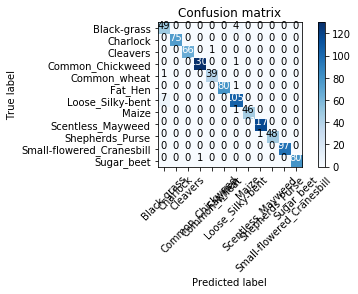

In [61]:
plot_confusion_matrix(cm, data.classes)

# Train with Everything

In [36]:
# Move all validation data except one (due to fastai limitation) to training data
data = get_data(sz,bs,[0])
learn.set_data(data)

In [37]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                   
    0      0.0452     7e-05      1.0       
    1      0.049032   3.8e-05    1.0                        
    2      0.044067   4.9e-05    1.0                        
    3      0.044347   4e-05      1.0                        
    4      0.049083   5.1e-05    1.0                        
    5      0.048378   6.9e-05    1.0                        
    6      0.047158   2.2e-05    1.0                        


[array([0.00002]), 1.0]

# Create Submission

In [38]:
log_preds_test, _ = learn.TTA(is_test=True)
probs_test = np.mean(np.exp(log_preds_test), 0)
preds_test = np.argmax(probs_test, axis=1)

In [39]:
preds_classes = [data.classes[i].replace("_", " ") for i in preds_test]

In [40]:
submission = pd.DataFrame({'file': os.listdir(f'{PATH}test'), 'species': preds_classes})
submission.to_csv(f'./output/plant-seedlings-resnet50.csv', index=False)

Kaggle Score Mean F-Score: 
1. __0.98488__  (224,299)
2. __0.98614__  (224,320)
3. __0.98236__  (224,320)

In [48]:
FileLink(f'./output/plant-seedlings-resnet50.csv')

/home/szelee/kaggle/plant-seedlings-classification/output/plant-seedlings-resnet50.csv